# Durablility Factor

In [1]:
restaurant_name = "Oscars - Ramee Royal Hotel"
#Time Cafe - Ramee Royal Hotel
#Oscars - Ramee Royal Hotel
#It's Mirchi - Ramee Royal Hotel

#Joe's Crab Shack
#Yogurtland

In [2]:
import mysql.connector
import pandas as pd
from datetime import datetime
import math
from google.cloud import secretmanager

PROJECT_ID = 'alpha-274108'

def access_secret_version(self,project_id, secret_id, version_id):
    """
    Access the payload for the given secret version if one exists. The version
    can be a version number as a string (e.g. "5") or an alias (e.g. "latest").
    """
    # Create the Secret Manager client.
    client = secretmanager.SecretManagerServiceClient()

    # Build the resource name of the secret version.
    name = client.secret_version_path(project_id, secret_id, version_id)

    # Access the secret version.
    response = client.access_secret_version(name)
    
    payload = response.payload.data.decode('UTF-8')
    return format(payload)


HOSTNAME = access_secret_version(PROJECT_ID, 'CHOST-A', 'latest'),
USER = access_secret_version(PROJECT_ID, 'CHOST-A-USER', 'latest'),
PASSWORD = access_secret_version(PROJECT_ID, 'CHOST-A-PASS', 'latest'),
DATABASE = 'sydney_zomato_database'

def dbConnect():
    mydb = mysql.connector.connect(
        host=HOSTNAME,
        user=USER,
        passwd=PASSWORD,
        database=DATABASE
    )

    mycursor = mydb.cursor()

    return mydb, mycursor

In [3]:
user_std = 601.2968311833278
user_avg = 91.28872987274288

In [4]:
review_std = 1.718087813739413
review_avg = 0.8862201301365501

In [5]:
mydb, mycursor = dbConnect()

# select id,entity_id and website url from zomato_dubai table based on the condition of is_crawled
sql = "SELECT r.helpful_count,r.reviewed_on,r.rating,u.follower_count FROM reviews r, users u WHERE r.entity_id IN (SELECT id FROM entity WHERE entity_id IN (SELECT id FROM service_entity WHERE name = %s)) AND u.id = r.user_id"
val = (restaurant_name,)
mycursor.execute(sql, val)

# create a dataframe from result of the previou sql query
df = pd.DataFrame(mycursor.fetchall())

df.columns = ['helpful_count','reviewed_on','rating','follower_count']

    

In [6]:
sql2 = "SELECT es.positive_reviews_count, es.rating_count FROM entity_summary es WHERE es.entity_id IN (SELECT id FROM entity WHERE entity_id IN (SELECT id FROM service_entity WHERE name = %s))"
val2 = (restaurant_name,)
mycursor.execute(sql2,val2)

pos_rating_count_df = pd.DataFrame(mycursor.fetchall())
mycursor.close()

pos_rating_count_df.columns = ['positive_reviews_count','rating_count']

pos = int(pos_rating_count_df.loc[0,'positive_reviews_count'])
n =  pos_rating_count_df.loc[0,'rating_count']

In [7]:
print("Positive Rating Count : ",pos)
print("Total Rating Count : ",n)

Positive Rating Count :  75
Total Rating Count :  75


In [8]:
type(n)

numpy.int64

In [9]:
def convertMS(ms):
    s = math.floor(ms / 1000)
    m = math.floor(s / 60)
    s = s % 60
    h = math.floor(m / 60)
    m = m % 60
    d = math.floor(h / 24)
    h = h % 24
    return d



In [10]:
def calculateHelpfulnessScoreUser(follower_count):
    helpfullnessScore = 1
    if ((follower_count - user_avg) > 0):
        helpfullnessScore = 1 + ((follower_count - user_avg) / user_std)
    
    return helpfullnessScore


In [11]:
def calculateHelpfulnessScoreReview(helpfulCount):
    helpfullnessScore = 1
    if ((helpfulCount - review_avg) > 0):
        helpfullnessScore = 1 + ((helpfulCount - review_avg) / review_std)
    
    return helpfullnessScore

In [12]:
def calculateDurability(reviewed_on):
    current_date = datetime.strptime("2019-07-12 13:27:53",'%Y-%m-%d %H:%M:%S').timestamp() * 1000
    dt_obj = datetime.strptime(reviewed_on,'%Y-%m-%d %H:%M:%S')
    reviewed_date = dt_obj.timestamp() * 1000
    diff = current_date - reviewed_date
    days = convertMS(diff)
    return 1 - math.exp(-math.exp(-0.045 * (math.ceil(days / 7) - 65)))
    

In [13]:
def wilson_score(pos, n):
    if (n == 0):
        return 0
    # Corresponds to an 99.975% confidence on the entities with least amount of reviews.
    z = 3.6622599308876151
    phat = 1 * pos / n
    return (phat + z*z/(2*n) - z * math.sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n)

In [14]:
sum_dhr = 0
sum_dhrs = 0
for row in range(df.shape[0]):
    sum_dhr += calculateHelpfulnessScoreUser(int(df.loc[row,'follower_count']))*calculateHelpfulnessScoreUser(int(df.loc[row,'helpful_count']))*calculateDurability(df.loc[row,'reviewed_on'])
    sum_dhrs += calculateHelpfulnessScoreUser(int(df.loc[row,'follower_count']))*calculateHelpfulnessScoreUser(int(df.loc[row,'helpful_count']))*calculateDurability(df.loc[row,'reviewed_on'])*float(df.loc[row,'rating'])
    
entity_score_weighted = sum_dhrs/sum_dhr
global_rank = (sum_dhrs/sum_dhr)*wilson_score(pos,n)

print("Weight Score : ", entity_score_weighted)
print("Wilson Score : ",wilson_score(pos,n))
print("Global Rank : ", global_rank)


Weight Score :  4.915842482010996
Wilson Score :  0.8482997174606037
Global Rank :  4.170107788570761


In [15]:
reviewed_date_list = df['reviewed_on'].tolist()
current_date = datetime.strptime("2019-07-12 13:27:53",'%Y-%m-%d %H:%M:%S').timestamp() * 1000
x = []
for item in reviewed_date_list:
    dt_obj = datetime.strptime(item,'%Y-%m-%d %H:%M:%S')
    reviewed_date = dt_obj.timestamp() * 1000
    diff = current_date - reviewed_date
    x.append(convertMS(diff))
x.sort()   

In [98]:
x = np.linspace(30,730,105)

In [99]:
#x

In [100]:
y = []
for item in x:
    y.append(1 - math.exp(-math.exp(-0.1 * (math.ceil(item / 5) - 50))))

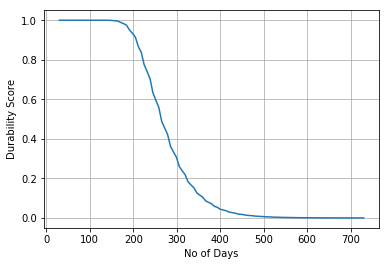

In [101]:
plt.plot(x, y)
plt.grid()
plt.xlabel('No of Days')
plt.ylabel('Durability Score')
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

         
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1,1,1)
spacing = 50 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)
#ax1.plot(9 * np.random.rand(10))
ax1.plot(y)
# Set minor tick locations.
ax1.yaxis.set_minor_locator(minorLocator)
ax1.xaxis.set_minor_locator(minorLocator)
# Set grid to use minor tick locations. 
ax1.grid(which = 'minor')


# plt.plot(x, y)
# plt.grid( linestyle='-', linewidth=2, line)
plt.xlabel('No of Days')
plt.ylabel('Durability Score')
plt.show()

<Figure size 800x800 with 1 Axes>

In [ ]:

users_count = np.linspace(1,df.shape[0],df.shape[0])     
follower_count_list = df['follower_count'].tolist()
user_rank = []
for item in follower_count_list:
    user_rank.append(calculateHelpfulnessScoreUser(float(item)))
plt.figure()
plt.plot(users_count, user_rank)
plt.grid()
plt.xlabel('User Index')
plt.ylabel("Helpfulness of Users")
plt.show()


In [18]:

review_count = np.linspace(1,df.shape[0],df.shape[0])     
helpful_count_list = df['helpful_count'].tolist()
review_rank = []
for item in helpful_count_list:
    review_rank.append(calculateHelpfulnessScoreReview(float(item)))
plt.figure()
plt.plot(review_count, review_rank)
plt.grid()
plt.xlabel('Review Index')
plt.ylabel("Helpfulness of Review")
plt.show()


NameError: name 'np' is not defined